# Mask Detection Assignment

## CNNs - Convolutional Neural Networks

The task required to identify images representing groups of people and divide them in three classes:
- All the people in the image are wearing a mask **(ID 0)**
- No person in the image is wearing a mask **(ID 1)**
- Someone in the image is not wearing a mask **(ID 2)**

We were provided with 5614 labeled images not divided in training/validation sets; we choose to utilize **10% of the images as the validation set**.

The test set is unlabeled for competition purposes and is composed of 450 images.

We started by using the dataset to train the models seen in laboratory sessions and modyfing hyperparameters by hand to get an understanding of what changes caused the network to improve the accuracy/loss on the validation set.

### Image size

We used an image size of **224x224** since it was commonly used in a lot of pretrained networks.

### Data Augmentation

As for data augmentation we applied little width and height shifts and modified the brightness due to images in the dataset having very different lightnings


### Final CNN model

For the final model designing a network from scratch, we opted for a structure inspired by *VGG16 model*, with more convolutional layers per 'block'

This model identified the testset with a precision of **67.333%** after training for two times with little differences in the image augmentation

We then proceded to apply transfer learning to try achieving better results 


## Transfer learning

We tried to begin implementing Transfer Learning again by copying what was done in Laboratory lessons, and got a ~80% accuracy on the test set without modifying much. Using this value as reference we tried with a lot of other networks. 
 
Since the starting network used in Lab was VGG16 we tried with VGG19 but didn't have that much of an improvement in classification.

We tried training with different ResNet networks, a couple from DenseNet, but got the most from using MobileNet and MobileNetV2

The final approach reached ~ 93% accuracy using MobileNetV2 feature layer obtained from TensorFlow HUB

Oddly enough, trying to train other networks only training specific parts of the network a time did not outperform the simple solution using MobileNetV2 features + a Dense classification layer with softmax activation.

Adding an intermediate Dense layer (with 256, 512, 1024, 2048) neurons (with or without Dropout to prevent overfitting) did not help getting a better result on the testset.


# Kaggle configuration

We setup the notebook to use kaggle APIs to download the dataset and at the end to automatically upload the csv file with the predicted solution on the dataset



In [ ]:
# We import the dataset directly from Kaggle using the Kaggle API
!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/68/6d/9b/7a98271454edcba3b56328cbc78c037286e787d004c8afee71/kaggle-1.5.9-cp36-none-any.whl
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


To use the Kaggle API it is needed to import the kaggle.json file with the token, complete instructions on [github](https://github.com/Kaggle/kaggle-api)




In [ ]:
from google.colab import files
files.upload()

In [ ]:
# Create .kaggle folder in the home directory, copy the kaggle.json file into it.
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/

# Lastly, set file permissions
!chmod 600 ~/.kaggle/kaggle.json
!ls -al ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
total 16
drwxr-xr-x 2 root root 4096 Nov 20 16:12 .
drwx------ 1 root root 4096 Nov 20 16:13 ..
-rw------- 1 root root   67 Nov 20 16:37 kaggle.json


In [ ]:
# Download the challenge files and unzip in the correct folder
!kaggle competitions download -c artificial-neural-networks-and-deep-learning-2020

artificial-neural-networks-and-deep-learning-2020.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -qn artificial-neural-networks-and-deep-learning-2020.zip
!ls MaskDataset/

test  train_gt.json  training


**TensorFlow Setup**

In [ ]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image

if os.getcwd() != '/content/MaskDataset':
  %cd MaskDataset 

# Set the seed for random operations
SEED = 0xDEADBEEF
tf.random.set_seed(SEED)  

training_dir = 'training'
test_dir = 'test'

# To see how many training images and test images have been found
print(f'Found {len(os.listdir(training_dir))} training images')
print(f'Found {len(os.listdir(test_dir))} test images')

Found 5614 training images
Found 450 test images


In [ ]:
import json
import pandas as pd

ground_truth = pd.read_json('train_gt.json', typ='series')

dataframe = pd.DataFrame(ground_truth.items(), columns=['filename', 'class'], dtype=str)

dataframe = dataframe.sample(frac=1, random_state=SEED)

num_validation = int(len(dataframe) * 0.2)

training_dataframe = dataframe[:-num_validation]
validation_dataframe = dataframe[-num_validation:]

# To see the file name and the correspondent class for training_dataframe and validation_dataframe
print(training_dataframe)
print(validation_dataframe)

       filename class
4801  15188.jpg     2
2682  11845.jpg     1
5449  13971.jpg     2
2208  13963.jpg     1
3331  11708.jpg     1
...         ...   ...
4421  11132.jpg     2
4722  14490.jpg     2
5173  12816.jpg     2
3918  15943.jpg     2
2295  16536.jpg     1

[4492 rows x 2 columns]
       filename class
71    14100.jpg     0
3934  13924.jpg     2
4393  12890.jpg     2
3944  12705.jpg     2
3224  13896.jpg     1
...         ...   ...
1873  14441.jpg     0
2146  15124.jpg     1
3436  10187.jpg     1
3041  13791.jpg     1
3800  16150.jpg     2

[1122 rows x 2 columns]


**ImageDataGenerator**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(brightness_range=[0.8, 1.2],
                                        rotation_range=0.1,
                                        width_shift_range=0.075,
                                        height_shift_range=0.075,
                                        # vertical_flip=True,
                                        horizontal_flip=True,
                                        fill_mode='nearest',
                                        rescale=1./255,
                                        )
else:
    train_data_gen = ImageDataGenerator(rescale=1./255)

# Create validation ImageDataGenerator objects    
valid_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
BATCH_SIZE = 128

IMG_SIZE = 224

CLASSES = [
  'no_one',
  'someone',
  'everybody'
]

def to_generator(data_generator: ImageDataGenerator, dataframe: pd.DataFrame):
  return data_generator.flow_from_dataframe(dataframe,
                                            training_dir,    
                                            color_mode='rgb',
                                            batch_size=BATCH_SIZE,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            shuffle=True,
                                            seed=SEED)

# Training
train_gen = to_generator(train_data_gen, training_dataframe)
# Validation
valid_gen = to_generator(valid_data_gen, validation_dataframe)

Found 4492 validated image filenames belonging to 3 classes.
Found 1122 validated image filenames belonging to 3 classes.


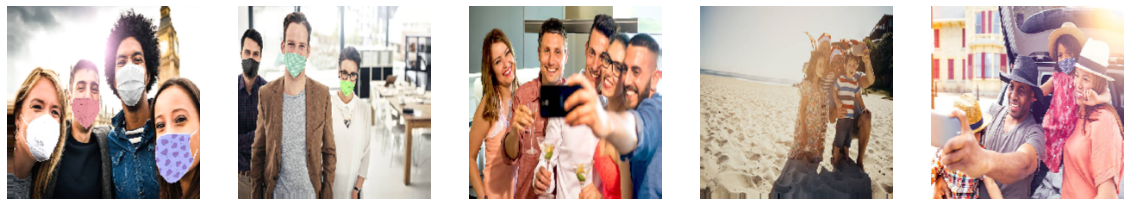

In [ ]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

# Displays 5 images horizontally to visualize the training set
def show_horizontally(images):
    fig = figure(figsize=(20, 90))
    number_of_files = len(images)
    for i in range(number_of_files):
        a = fig.add_subplot(1, number_of_files, i + 1)
        imshow(images[i])
        axis('off')

x = train_gen.next()[0][:5]

show_horizontally(x)

In [ ]:
# Create Dataset objects
def to_dataset(generator):
  dataset = tf.data.Dataset.from_generator(lambda: generator,
                                            output_types=(tf.float32, tf.float32),
                                            output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(CLASSES)]))
  dataset.repeat()
  return dataset

train_dataset = to_dataset(train_gen)
valid_dataset = to_dataset(valid_gen)

In [ ]:
from tensorflow.keras.layers import Conv2D, ReLU, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

# Initializing a Sequential model
model = Sequential()

# Define network characteristics
start_filters = 16
depth = 4

kernel_size = (3, 3)
strides = (1, 1)
padding = 'same'
activation = 'relu'
pool_size = (2, 2)
pool_strides = (2, 2)

# Creates *depth* convolutional blocks for feature extraction
for i in range(depth):
    input_shape = (IMG_SIZE, IMG_SIZE, 3) if i == 0 else [None]
    
    for j in range(2):
        model.add(Conv2D(filters=start_filters * (2**i), 
                        kernel_size=kernel_size, 
                        strides=strides, 
                        padding=padding, 
                        input_shape=input_shape, 
                        activation=activation))
    
    model.add(MaxPool2D(pool_size=pool_size, strides=pool_strides))

# Flattening the pooled image pixels
model.add(Flatten())

# Creating 2 Dense Layers
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))

# Creating an output layer
model.add(Dense(units=len(CLASSES), activation='softmax'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_136 (Conv2D)          (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 112, 112, 32)      4640      
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 56, 56, 64)      

In [ ]:
# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                 mode = 'min',
                                                 min_delta = 0.005,
                                                 patience = 5,
                                                 verbose = 1,
                                                 restore_best_weights = True)

checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5',
                                                  monitor='val_loss',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  save_weights_only=True,
                                                  mode='min')

In [ ]:
# Fit the model

def fit_model(model):
  history = model.fit(train_dataset, 
                      epochs=60,
                      steps_per_epoch=len(train_gen),
                      validation_steps=len(valid_gen),
                      validation_data = valid_dataset,
                      callbacks=[early_stopper, checkpoint])
  return history


In [ ]:
fit_model(model)

Epoch 1/60
40/40 [==============================] - ETA: 0s - loss: 0.7266 - accuracy: 0.6594
Epoch 00001: val_loss did not improve from 0.74039
40/40 [==============================] - 84s 2s/step - loss: 0.7266 - accuracy: 0.6594 - val_loss: 0.7780 - val_accuracy: 0.6292
Epoch 2/60
40/40 [==============================] - ETA: 0s - loss: 0.7097 - accuracy: 0.6723
Epoch 00002: val_loss did not improve from 0.74039
40/40 [==============================] - 84s 2s/step - loss: 0.7097 - accuracy: 0.6723 - val_loss: 0.7642 - val_accuracy: 0.6435
Epoch 3/60
40/40 [==============================] - ETA: 0s - loss: 0.7189 - accuracy: 0.6638
Epoch 00003: val_loss did not improve from 0.74039
40/40 [==============================] - 83s 2s/step - loss: 0.7189 - accuracy: 0.6638 - val_loss: 0.7792 - val_accuracy: 0.6346
Epoch 4/60
40/40 [==============================] - ETA: 0s - loss: 0.7162 - accuracy: 0.6711
Epoch 00004: val_loss did not improve from 0.74039
40/40 [==========================

# Transfer Learning

We load from Tensorflow HUB the feature layer from MobileNetV2 and simply attach a Dense layer for classification.

We then procede to train the model with the feature layer frozen from training, then train it again, unlocking the feature layer for fine tuning.



In [ ]:
import tensorflow_hub as hub

feature_extractor = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", input_shape=(IMG_SIZE, IMG_SIZE, 3))
feature_extractor.trainable = False

# Create model
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Visualize model
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_46 (Dense)             (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
fit_model(model)

Epoch 1/60
40/40 [==============================] - ETA: 0s - loss: 1.1805 - accuracy: 0.4049
Epoch 00001: val_loss did not improve from 0.71705
40/40 [==============================] - 82s 2s/step - loss: 1.1805 - accuracy: 0.4049 - val_loss: 1.0775 - val_accuracy: 0.4349
Epoch 2/60
40/40 [==============================] - ETA: 0s - loss: 1.0998 - accuracy: 0.4512
Epoch 00002: val_loss did not improve from 0.71705
40/40 [==============================] - 82s 2s/step - loss: 1.0998 - accuracy: 0.4512 - val_loss: 0.9993 - val_accuracy: 0.4938
Epoch 3/60
40/40 [==============================] - ETA: 0s - loss: 1.0337 - accuracy: 0.4914
Epoch 00003: val_loss did not improve from 0.71705
40/40 [==============================] - 82s 2s/step - loss: 1.0337 - accuracy: 0.4914 - val_loss: 0.9422 - val_accuracy: 0.5241
Epoch 4/60
40/40 [==============================] - ETA: 0s - loss: 0.9857 - accuracy: 0.5126
Epoch 00004: val_loss did not improve from 0.71705
40/40 [==========================

In [ ]:
feature_extractor.trainable = True
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_46 (Dense)             (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
model.load_weights('/content/MaskDataset/model(4).h5')

In [ ]:
fit_model(model)

Epoch 1/60
36/36 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9822
Epoch 00001: val_loss improved from 0.04280 to 0.04273, saving model to model.h5
36/36 [==============================] - 75s 2s/step - loss: 0.0589 - accuracy: 0.9822 - val_loss: 0.0427 - val_accuracy: 0.9840
Epoch 2/60
36/36 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9797
Epoch 00002: val_loss improved from 0.04273 to 0.04268, saving model to model.h5
36/36 [==============================] - 75s 2s/step - loss: 0.0620 - accuracy: 0.9797 - val_loss: 0.0427 - val_accuracy: 0.9840
Epoch 3/60
36/36 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9802
Epoch 00003: val_loss improved from 0.04268 to 0.04264, saving model to model.h5
36/36 [==============================] - 75s 2s/step - loss: 0.0600 - accuracy: 0.9802 - val_loss: 0.0426 - val_accuracy: 0.9840
Epoch 4/60
36/36 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0

# Result CSV file creation

We define a function (taken from the evaluation section from the competition on Kaggle) to transform the dictionary we will create with the images as keys and predictions as values into a correctly formatted file for evaluation.

Finally, using Kaggle API again we upload directly the file for evaluation.

In [ ]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):
    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

    return os.path.join(results_dir, csv_fname)

In [ ]:
from PIL import Image
from collections import defaultdict
import json 
import tqdm
import time

results = defaultdict()

# Cycle through all the images, tranform everyone into a numpy array, 
# get a prediction and add it to the dictionary.
for img in tqdm.tqdm(os.listdir(test_dir), desc='Getting predictions from images'):
  img_dir = os.path.join(test_dir, img)

  image = Image.open(img_dir).convert('RGB')
  image = image.resize((IMG_SIZE, IMG_SIZE))

  img_arr = np.expand_dims(np.array(image), 0) 

  out_softmax = model.predict(x=img_arr / 255.)
  predicted_class = tf.argmax(out_softmax, 1).numpy()[0]

  results[img] = predicted_class

Getting predictions from images: 100%|██████████| 450/450 [00:20<00:00, 22.40it/s]


In [ ]:
print(f'Processing {len(results)} results...')

submission = create_csv(results)

Processing 450 results...


In [ ]:
# Uploading the results to be scored
!kaggle competitions submit -c artificial-neural-networks-and-deep-learning-2020 -f {submission} -m "submission"

100% 5.29k/5.29k [00:07<00:00, 690B/s]
Successfully submitted to Artificial Neural Networks and Deep Learning 2020

In [ ]:
# Showing the leaderboard
!kaggle competitions leaderboard -c artificial-neural-networks-and-deep-learning-2020 --show